In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [2]:
df = pd.read_csv('final_dataset_v2.csv')
df = df[df['log_revenue'] > 0] # reflect chagne in 02
# drop runtime_bucket in 02
X = df.drop(columns=['log_revenue', 'title_x', 'title_y', 'movie_id', 'runtime_bucket'], errors='ignore')
y = df['log_revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
def evaluate_model(y_true, y_pred, name="Model"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"\n{name} Performance:")
    print(f"MAE:  {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R^2:  {r2:.2f}")
    return mae, rmse, r2
def train_and_evaluate(model, X_train, y_train, X_test, y_test, name="Model"):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return evaluate_model(y_test, y_pred, name)

Baseline Model

In [4]:
y_pred_baseline = np.full_like(y_test, y_train.mean())
evaluate_model(y_test, y_pred_baseline, "Baseline")


Baseline Performance:
MAE:  1.61
RMSE: 2.29
R^2:  -0.00


(1.613308951352184, np.float64(2.2874398777069946), -5.823545299321609e-06)

Random Forest

In [5]:
rf_model = RandomForestRegressor(random_state=42)
train_and_evaluate(rf_model, X_train, y_train, X_test, y_test, "Random Forest")


Random Forest Performance:
MAE:  0.80
RMSE: 1.31
R^2:  0.67


(0.7971578091801063, np.float64(1.312224531338098), 0.6709063838209466)

XGBoost

In [6]:
xgb_default = XGBRegressor(random_state=42)
train_and_evaluate(xgb_default, X_train, y_train, X_test, y_test, "XGBoost Default")


XGBoost Default Performance:
MAE:  0.81
RMSE: 1.28
R^2:  0.69


(0.809679528651062, np.float64(1.2813379224368469), 0.6862162040923798)

Cross-Validation for XGBoost

In [7]:
cv_scores = cross_val_score(xgb_default, X, y, cv=5, scoring='neg_mean_absolute_error')
print("\nXGBoost Cross-Validated MAE:", -cv_scores.mean())


XGBoost Cross-Validated MAE: 0.8855940794361231


Hyperparameter Tuning

In [8]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [0.5, 1, 2]
}
tuner = RandomizedSearchCV(
    XGBRegressor(random_state=42),
    param_distributions=param_grid,
    scoring='neg_mean_absolute_error',
    n_iter=30,
    cv=3,
    verbose=1,
    n_jobs=-1
)
tuner.fit(X_train, y_train)
print("\nBest Parameters:", tuner.best_params_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits

Best Parameters: {'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha': 1, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 0.8}


XGboost Model with Tuned Parameters

In [9]:
xgb_tuned = tuner.best_estimator_
train_and_evaluate(xgb_tuned, X_train, y_train, X_test, y_test, "XGBoost Tuned")


XGBoost Tuned Performance:
MAE:  0.76
RMSE: 1.24
R^2:  0.70


(0.76356274172992, np.float64(1.2446824062284378), 0.703912376233129)

In [10]:
importances = xgb_tuned.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

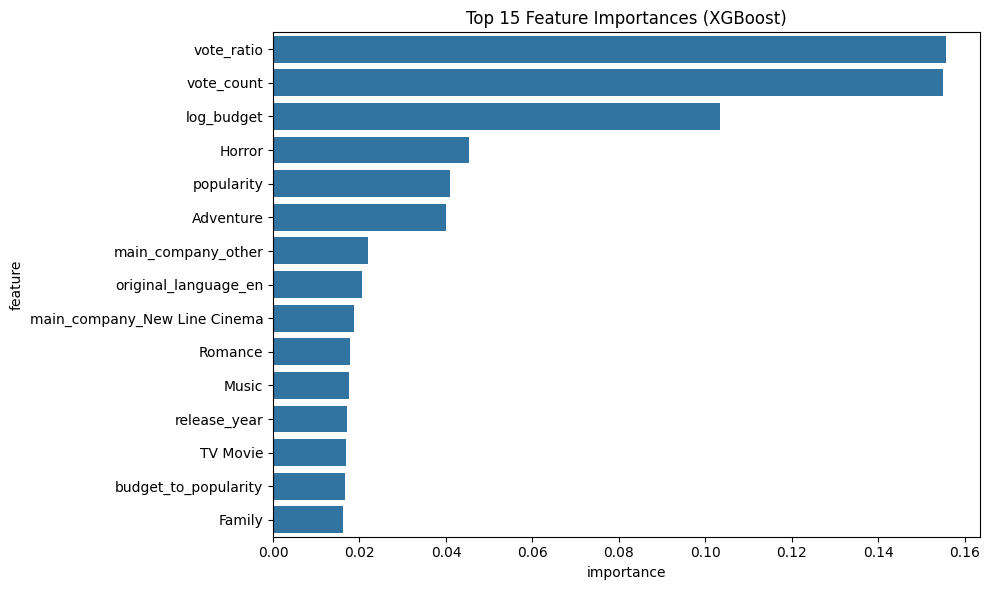

In [11]:
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_df.head(15), x='importance', y='feature')
plt.title("Top 15 Feature Importances (XGBoost)")
plt.tight_layout()
plt.show()

Dropping leaky features from the full dataset

Testing feature interactions

In [12]:
X_interact = X.copy()
X_interact['budget_popularity'] = X_interact['log_budget'] * X_interact['popularity']
X_interact['budget_vote_ratio'] = X_interact['log_budget'] * X_interact['vote_ratio']


# Split
X_train, X_test, y_train, y_test = train_test_split(X_interact, y, test_size=0.2, random_state=42)

# Train model
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
evaluate_model(y_test, y_pred, name="XGBoost with Feature Interactions")


XGBoost with Feature Interactions Performance:
MAE:  0.82
RMSE: 1.28
R^2:  0.69


(0.822495394046176, np.float64(1.2778169404994701), 0.687938324516616)

In [13]:
X_interact['runtime_budget'] = X_interact['runtime'] * X_interact['log_budget']
X_interact['budget_year'] = X_interact['log_budget'] * X_interact['release_year']
X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(X_interact, y, test_size=0.2, random_state=42)
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train_i, y_train_i)
y_pred_i = xgb_model.predict(X_test_i)
evaluate_model(y_test_i, y_pred_i, name="XGB with Extra Interactions")


XGB with Extra Interactions Performance:
MAE:  0.80
RMSE: 1.25
R^2:  0.70


(0.7997127698037192, np.float64(1.254627541778521), 0.6991619346956475)

In [14]:
param_grid = {
    'n_estimators': [200, 300],
    'max_depth': [5, 7],
    'learning_rate': [0.05, 0.1],
}

grid_search = GridSearchCV(
    XGBRegressor(random_state=42),
    param_grid,
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train_i, y_train_i)
print("Best Parameters:", grid_search.best_params_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Parameters: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200}


In [15]:
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test_i)
evaluate_model(y_test_i, y_pred_best, name="Tuned XGB via GridSearch")


Tuned XGB via GridSearch Performance:
MAE:  0.76
RMSE: 1.22
R^2:  0.71


(0.7617876729965433, np.float64(1.2233577618586173), 0.7139709678028026)

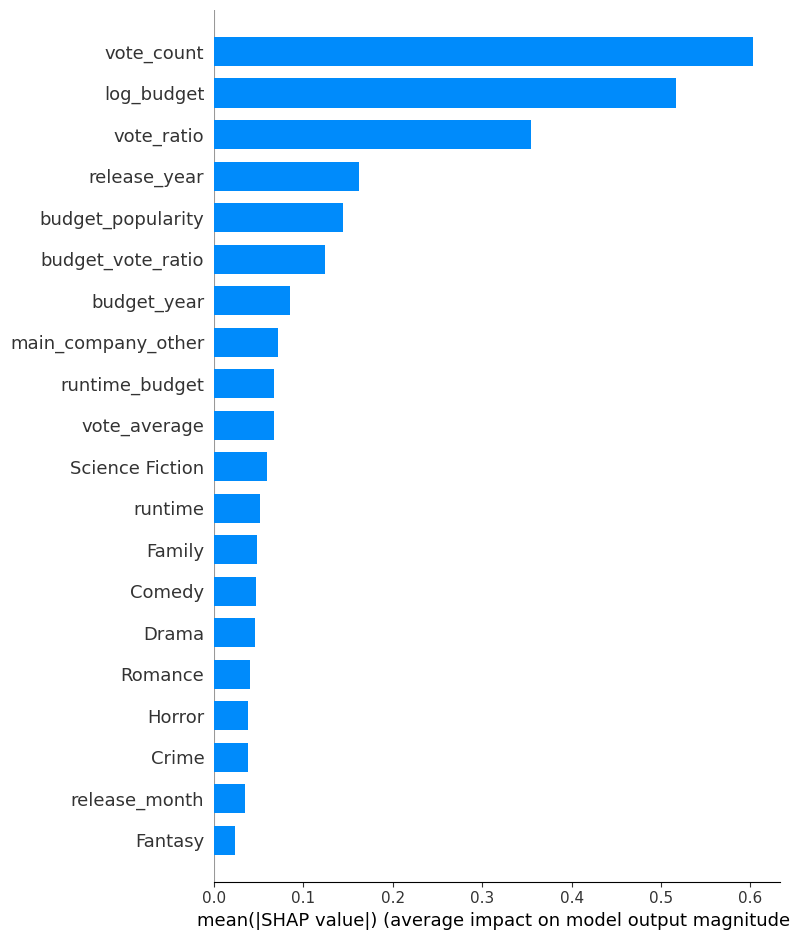

In [16]:
import shap
import matplotlib.pyplot as plt

# Use TreeExplainer (safe for XGBoost on CPU)
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test_i)

# Summary Plot (bar or violin style)
shap.summary_plot(shap_values, X_test_i, plot_type="bar")  # use 'bar' for safety

In [17]:
mean_shap_vals = np.abs(shap_values).mean(axis=0)
shap_df = pd.DataFrame({
    "feature": X_test_i.columns,
    "mean_abs_shap": mean_shap_vals
}).sort_values(by="mean_abs_shap", ascending=False)

In [18]:
threshold = 0.00175
low_impact_features = shap_df[shap_df["mean_abs_shap"] < threshold]["feature"].tolist()
low_impact_features

['director_Martin Scorsese',
 'actor_Julia_Roberts',
 'actor_Johnny_Depp',
 'Mystery',
 'History',
 'actor_Robert_De_Niro',
 'actor_Nicolas_Cage',
 'original_language_cn',
 'original_language_other',
 'director_Clint Eastwood',
 'original_language_ja',
 'director_Renny Harlin',
 'director_Steven Soderbergh',
 'main_company_Walt Disney Pictures',
 'main_company_Metro-Goldwyn-Mayer',
 'main_company_New Line Cinema',
 'original_language_es',
 'original_language_fr',
 'director_Robert Rodriguez',
 'main_company_Touchstone Pictures',
 'director_other',
 'actor_Tom_Cruise',
 'original_language_de',
 'main_company_20th Century Fox',
 'main_company_Columbia Pictures',
 'actor_Bruce_Willis',
 'actor_Matt_Damon',
 'director_Spike Lee',
 'director_Ridley Scott',
 'director_Unknown',
 'director_Woody Allen',
 'actor_Brad_Pitt',
 'actor_Samuel_L._Jackson',
 'actor_Ben_Stiller',
 'actor_Eddie_Murphy',
 'actor_Denzel_Washington',
 'actor_Mark_Wahlberg',
 'actor_Tom_Hanks',
 'is_holiday_release']

In [19]:
X_shap_reduced = X.drop(columns=low_impact_features)

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_shap_reduced, y, test_size=0.2, random_state=42)
best_model.fit(X_train_s, y_train_s)
y_pred_s = best_model.predict(X_test_s)

evaluate_model(y_test_s, y_pred_s, name="XGBoost with SHAP-based Feature Selection")


XGBoost with SHAP-based Feature Selection Performance:
MAE:  0.76
RMSE: 1.23
R^2:  0.71


(0.7598063774376007, np.float64(1.2284281757683901), 0.7115950625588006)

<Axes: ylabel='log_revenue'>

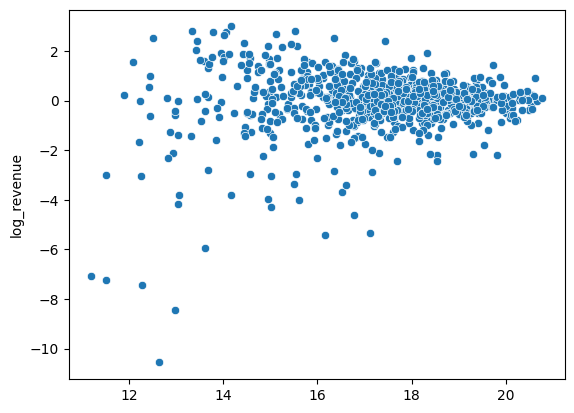

In [20]:
residuals  = y_test_s - y_pred_s
sns.scatterplot(x=y_pred_s, y=residuals)

array([[<Axes: title={'center': 'popularity'}>,
        <Axes: title={'center': 'vote_count'}>],
       [<Axes: title={'center': 'vote_ratio'}>,
        <Axes: title={'center': 'budget_to_popularity'}>]], dtype=object)

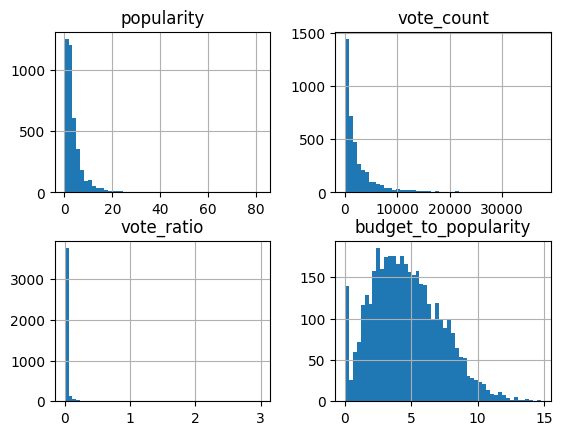

In [21]:
df[["popularity", "vote_count", "vote_ratio", "budget_to_popularity"]].hist(bins=50)


In [22]:
X["vote_popularity_product"] = X["vote_average"] * X["popularity"]
X["budget_vote_ratio"] = X["log_budget"] * X["vote_ratio"]

X_transformed = X.drop(columns=["popularity", "vote_count", "vote_ratio"])
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_transformed, y, test_size=0.2, random_state=42)
best_model.fit(X_train_log, y_train_log)
y_pred_log = best_model.predict(X_test_log)

evaluate_model(y_test_log, y_pred_log, name="XGBoost + Log-Transformed Features")


XGBoost + Log-Transformed Features Performance:
MAE:  0.75
RMSE: 1.20
R^2:  0.72


(0.7502089895915002, np.float64(1.2044968535277365), 0.722722587440542)

{'subsample': 0.8,
 'n_estimators': 300,
 'max_depth': 4,
 'learning_rate': 0.05,
 'gamma': 0,
 'colsample_bytree': 0.9}

In [28]:
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 0.9, 1],
    'colsample_bytree': [0.7, 0.9, 1],
    'gamma': [0, 1, 5]
}

xgb_base = XGBRegressor(random_state=42)
random_search = RandomizedSearchCV(xgb_base, param_distributions=param_grid,
                                   n_iter=30, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)

random_search.fit(X_train_log, y_train_log)

best_tuned_model = random_search.best_estimator_
y_pred_tuned = best_tuned_model.predict(X_test_log)
evaluate_model(y_test_log, y_pred_tuned, name="Tuned XGBoost Final")


Tuned XGBoost Final Performance:
MAE:  0.75
RMSE: 1.20
R^2:  0.73


(0.7533778470250188, np.float64(1.1991864241769596), 0.7251621391646017)

In [32]:
from sklearn.metrics import r2_score

# Inputs
r2 = r2_score(y_test_log, y_pred_tuned)
n = X_test_log.shape[0]
p = X_test_log.shape[1]

# Adjusted R²
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print(f"Adjusted R²: {adjusted_r2:.4f}")

Adjusted R²: 0.6968


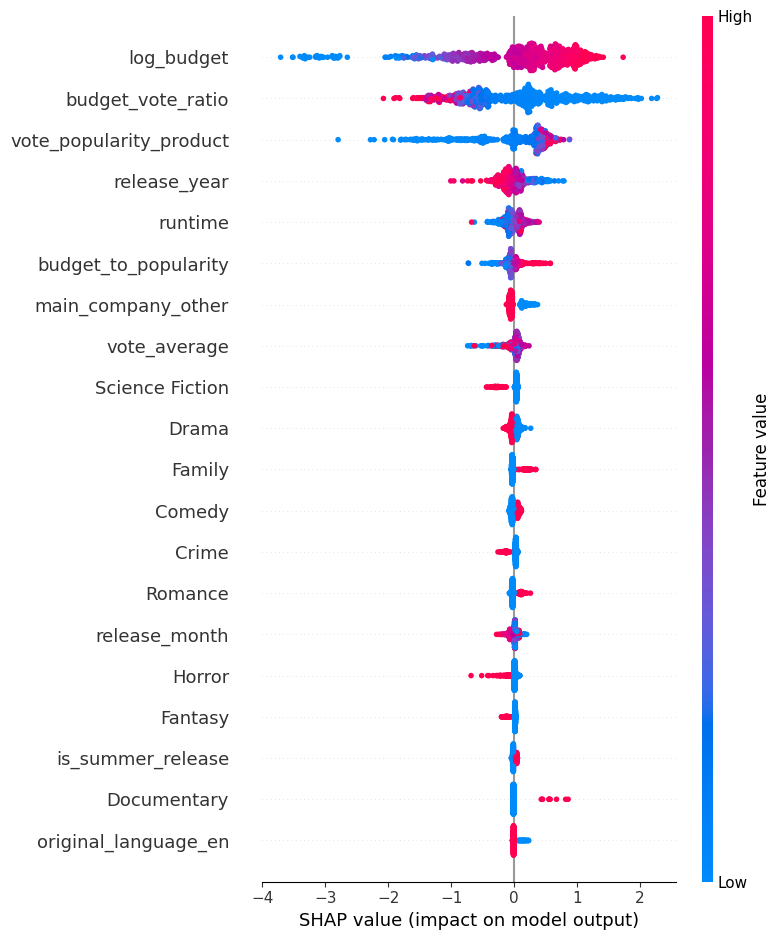

In [36]:
import shap

explainer = shap.TreeExplainer(best_tuned_model)
shap_values = explainer.shap_values(X_test_log)

shap.summary_plot(shap_values, X_test_log)  # visual

# Top features numerically
shap_importance = np.abs(shap_values).mean(axis=0)
shap_series = pd.Series(shap_importance, index=X_test_log.columns).sort_values(ascending=False)

Keep top 30-40 SHAP Features Only

In [51]:
top_k = 35
top_features = shap_series.head(top_k).index.tolist()

X_train_reduced = X_train_log[top_features]
X_test_reduced = X_test_log[top_features]

In [52]:
best_tuned_model.fit(X_train_reduced, y_train_log)
y_pred_reduced = best_tuned_model.predict(X_test_reduced)

from sklearn.metrics import r2_score

r2 = r2_score(y_test_log, y_pred_reduced)
n = X_test_reduced.shape[0]
p = X_test_reduced.shape[1]

adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print(f"R²: {r2:.4f} | Adjusted R²: {adjusted_r2:.4f}")

R²: 0.7249 | Adjusted R²: 0.7124
